# Unit Commitment

PyPSA-GB can model the GB power system by optimising the dispatch of generators by solving a Unit Commitment (UC) problem and fixing the commitment schedule. This notebook shows the solving of the Unit Commitment (UC) problem for a 3 day period.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import data_reader_writer

## Setting up simulation

Set the required inputs for the unit commitment: the start, end and year of simulation, the timestep, and true/false on outputting marginal prices

In [3]:
# attributes for running unit commitment
start = '2050-06-02 00:00:00'
end = '2050-06-04 23:30:00'
# year of simulation
year = 2050
# time step as fraction of hour
time_step = 0.5
# want marginal prices?
marginal_price = True

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [4]:
if year > 2020:

    # choose FES scenario
    scenario = 'Leading The Way'
    # scenario = 'Consumer Transformation'
    # scenario = 'System Transformation'
    # scenario = 'Steady Progression'

    year_baseline = 2012

    data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='historical', year_baseline=year_baseline, scenario=scenario)

elif year <= 2020:
    data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='historical')

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:201: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


Initilise and prepare network...

In [5]:
network = pypsa.Network()
network.import_from_csv_folder('UC_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 2], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network UC_data has buses, generators, links, loads, storage_units


## Running MILP and/or LP

The below cell runs the unit commitment. If marginal prices are not required then one MILP optimisation step is needed. If marginal prices are required then the MILP step is followed by fixing the generator status to convert to a LP which when solved gives marginal prices. 

In [6]:
if marginal_price is False:

    network.lopf(network.snapshots, solver_name="gurobi")

elif marginal_price is True:

    # Build a pyomo model corresponding to the pypsa network
    model = pypsa.opf.network_lopf_build_model(
        network, network.snapshots)
    # Prepare a pyomo optimizer object, here with gurobi
    opt = pypsa.opf.network_lopf_prepare_solver(
        network, solver_name="gurobi")
    # solve the MILP
    opt.solve(model).write()
    # fixing the generator_status makes the problem linear (LP)
    model.generator_status.fix()
    # solve again with fixed generators
    network.results = opt.solve(model)
    network.results.write()
    # import back to pypsa datastructures
    pypsa.opf.extract_optimisation_results(network, network.snapshots)

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x510193
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 1011317
  Number of variables: 510193
  Number of binary variables: 35712
  Number of integer variables: 35712
  Number of continuous variables: 474481
  Number of nonzeros: 3119228
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

## Outputs

In [7]:
# can now see marginal prices
network.buses_t.marginal_price

Bus,bus,Norway,N. Ireland,France2,Denmark,Germany,Belgium,Netherlands,Ireland,Ireland2,France1
snapshot,,,,,,,,,,,
2050-06-02 00:00:00,0.0,-1.0,-7.0,-15.0,-7.0,-20.0,-20.0,-20.0,-7.0,-7.0,-15.0
2050-06-02 00:30:00,0.0,-1.0,-7.0,-15.0,-7.0,-20.0,-20.0,-20.0,-7.0,-7.0,-15.0
2050-06-02 01:00:00,0.0,-1.0,-7.0,-15.0,-7.0,-20.0,-20.0,-20.0,-7.0,-7.0,-15.0
2050-06-02 01:30:00,0.0,-1.0,-7.0,-15.0,-7.0,-20.0,-20.0,-20.0,-7.0,-7.0,-15.0
2050-06-02 02:00:00,0.0,-1.0,-7.0,-15.0,-7.0,-20.0,-20.0,-20.0,-7.0,-7.0,-15.0
...,...,...,...,...,...,...,...,...,...,...,...
2050-06-04 21:30:00,0.0,-1.0,-7.0,-15.0,-7.0,-20.0,-20.0,-20.0,-7.0,-7.0,-15.0
2050-06-04 22:00:00,0.0,-1.0,-7.0,-15.0,-7.0,-20.0,-20.0,-20.0,-7.0,-7.0,-15.0
2050-06-04 22:30:00,0.0,-1.0,-7.0,-15.0,-7.0,-20.0,-20.0,-20.0,-7.0,-7.0,-15.0


In [8]:
network.generators_t.status

Generator,Hywind Scotland Pilot Park (Hywind 2) Demonstrator,Beatrice Demonstrator,Burbo Bank,Gunfleet Sands - (Demo) Extension,Gunfleet Sands II,Gunfleet Sands Offshore Wind Scheme,Inner Dowsing,Kentish Flats,Lynn,North Hoyle,...,Pem-Dem,Pen,Sca,St-Mar,Tir,Wav-Hub,Wes-Heb,Wes-Lew,Wes-Ork,Unmet Load
snapshot,,,,,,,,,,,,,,,,,,,,,
2050-06-02 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2050-06-02 00:30:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2050-06-02 01:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2050-06-02 01:30:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2050-06-02 02:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-06-04 21:30:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2050-06-04 22:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2050-06-04 22:30:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [9]:
network.generators_t.p

Generator,Hywind Scotland Pilot Park (Hywind 2) Demonstrator,Beatrice Demonstrator,Burbo Bank,Gunfleet Sands - (Demo) Extension,Gunfleet Sands II,Gunfleet Sands Offshore Wind Scheme,Inner Dowsing,Kentish Flats,Lynn,North Hoyle,...,Pem-Dem,Pen,Sca,St-Mar,Tir,Wav-Hub,Wes-Heb,Wes-Lew,Wes-Ork,Unmet Load
snapshot,,,,,,,,,,,,,,,,,,,,,
2050-06-02 00:00:00,0.0000,0.000000,0.0,0.000000,0.000000,29.267216,0.0,26.207389,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2050-06-02 00:30:00,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.315504,0.0,...,0.0,29.69967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2050-06-02 01:00:00,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2050-06-02 01:30:00,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2050-06-02 02:00:00,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-06-04 21:30:00,0.0000,3.679971,0.0,0.507826,3.109866,5.183110,0.0,0.000000,0.000000,0.0,...,0.0,8.42800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2050-06-04 22:00:00,10.3331,2.624134,0.0,0.000000,0.158964,0.264940,0.0,0.035283,0.000000,0.0,...,0.0,8.42800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2050-06-04 22:30:00,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [10]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0
p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

if year <= 2020:

    # interconnector exports
    exports = network.loads_t.p
    # multiply by negative one to convert it as a generator
    # i.e. export is a positive load, but negative generator
    exports['Interconnectors Export'] = exports.iloc[:, -6:].sum(axis=1) * -1
    interconnector_export = exports[['Interconnectors Export']]

elif year > 2020:
    print(network.links_t.p0)
    print(network.links_t.p1)
    imp = network.links_t.p0.copy()
    imp[imp < 0] = 0
    imp['Interconnectors Import'] = imp.sum(axis=1)
    interconnector_import = imp[['Interconnectors Import']]
    print(interconnector_import)
    p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

    exp = network.links_t.p0.copy()
    exp[exp > 0] = 0
    exp['Interconnectors Export'] = exp.sum(axis=1)
    interconnector_export = exp[['Interconnectors Export']]
    print(interconnector_export)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro and interconnector import
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

Link                 BritNed  EastWest  Moyle  Nemo     IFA    IFA2     NSL  \
snapshot                                                                      
2050-06-02 00:00:00      0.0       0.0    0.0   0.0   700.0  1750.0 -2450.0   
2050-06-02 00:30:00      0.0       0.0    0.0   0.0 -3500.0  1750.0  2450.0   
2050-06-02 01:00:00      0.0       0.0    0.0   0.0 -3500.0  1750.0  2450.0   
2050-06-02 01:30:00      0.0       0.0    0.0   0.0 -3500.0  1750.0 -2450.0   
2050-06-02 02:00:00      0.0       0.0    0.0   0.0 -3500.0  1750.0  2450.0   
...                      ...       ...    ...   ...     ...     ...     ...   
2050-06-04 21:30:00      0.0       0.0    0.0   0.0  -700.0  1750.0  2450.0   
2050-06-04 22:00:00      0.0       0.0    0.0   0.0 -3500.0  1750.0 -2450.0   
2050-06-04 22:30:00      0.0       0.0    0.0   0.0  3500.0  1750.0 -2450.0   
2050-06-04 23:00:00      0.0       0.0    0.0   0.0  -700.0  1750.0  2450.0   
2050-06-04 23:30:00      0.0       0.0    0.0   0.0 

,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,EfW Incineration,Hydrogen,Landfill Gas,Hydro,Natural Gas,...,Unmet Load,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,Pumped Storage Hydroelectric,Interconnectors Import,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2050-06-02 00:00:00,35.500000,0.0,0.0,0.0,0.0,86.24556,0.0,121.6,6.456553,0.0,...,0.0,0.00000,3781.290640,211.615586,0.000000,1182.690320,6.180672,1357.821782,6650.0,170.100000
2050-06-02 00:30:00,75.899999,0.0,0.0,0.0,0.0,337.96440,0.0,297.4,15.621690,0.0,...,0.0,29.69967,10154.120655,625.421781,0.000000,0.000000,0.000000,0.000000,7700.0,383.099999
2050-06-02 01:00:00,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,24.145913,2537.432294,519.099196,179.254689,509.183168,7700.0,0.000000
2050-06-02 01:30:00,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.000000,838.725619,1092.247782,0.000000,1255.985149,7700.0,0.000000
2050-06-02 02:00:00,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,3998.849889,78.720000,3331.879018,0.000000,0.000000,0.000000,7700.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-06-04 21:30:00,216.000000,0.0,0.0,0.0,0.0,500.60592,0.0,521.6,56.018134,0.0,...,0.0,12.53448,18700.927991,8051.476913,0.000000,0.000000,0.000000,0.000000,6650.0,772.800000
2050-06-04 22:00:00,317.600000,0.0,0.0,0.0,0.0,831.12156,0.0,743.5,98.250648,0.0,...,0.0,14.25200,14592.991632,8793.902621,0.000000,0.000000,0.000000,291.388394,7700.0,1111.300000
2050-06-04 22:30:00,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,6880.841128,0.000000,0.000000,0.000000,2998.646032,7700.0,0.000000


Graph the power output of the different generation types...

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

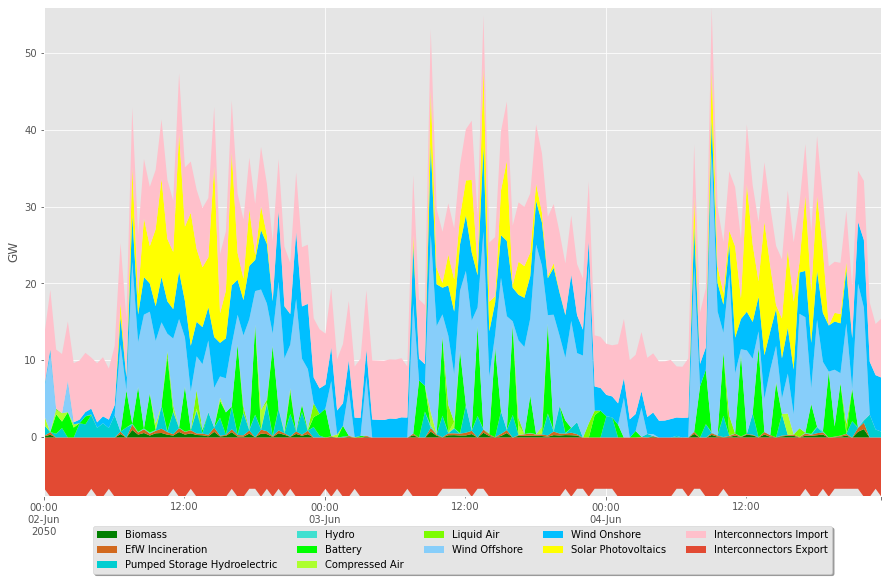

In [13]:
if year > 2020:

    cols = ["Nuclear", 'Biomass',
            'EfW Incineration', "Oil", "Natural Gas",
            'Hydrogen', 'CCS Gas', 'CCS Biomass',
            "Pumped Storage Hydroelectric", 'Hydro',
            'Battery', 'Compressed Air', 'Liquid Air',
            "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
            'Interconnectors Import', 'Unmet Load'
            ]

else:
    cols = ["Nuclear", 'Biomass',
            'EfW Incineration',
            "Coal", "Oil", "Natural Gas",
            "Pumped Storage Hydroelectric", 'Hydro',
            "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
            'Interconnectors Import'
            ]
# print(p_by_carrier['Pumped Storage Hydroelectric'])

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

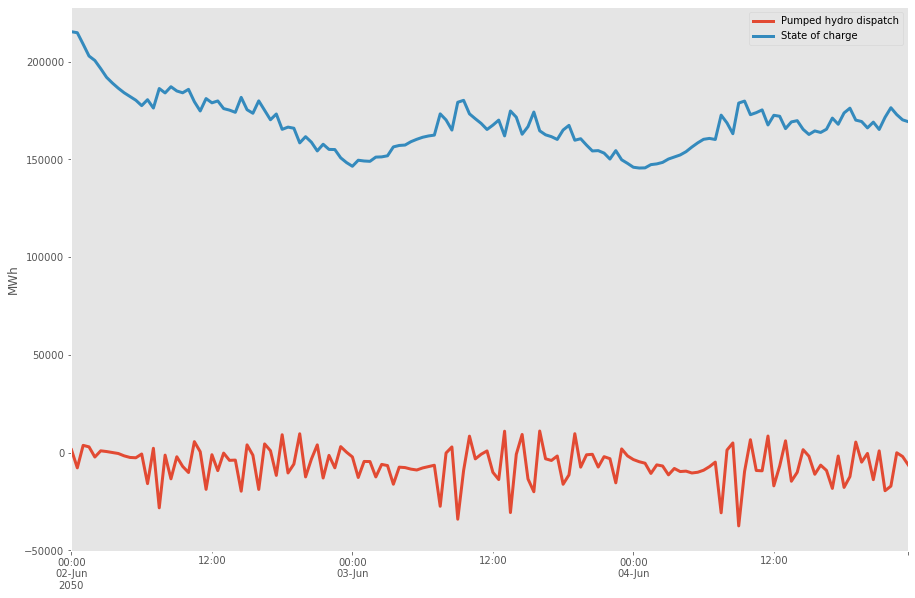

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

Graph the curtailment of onshore wind...

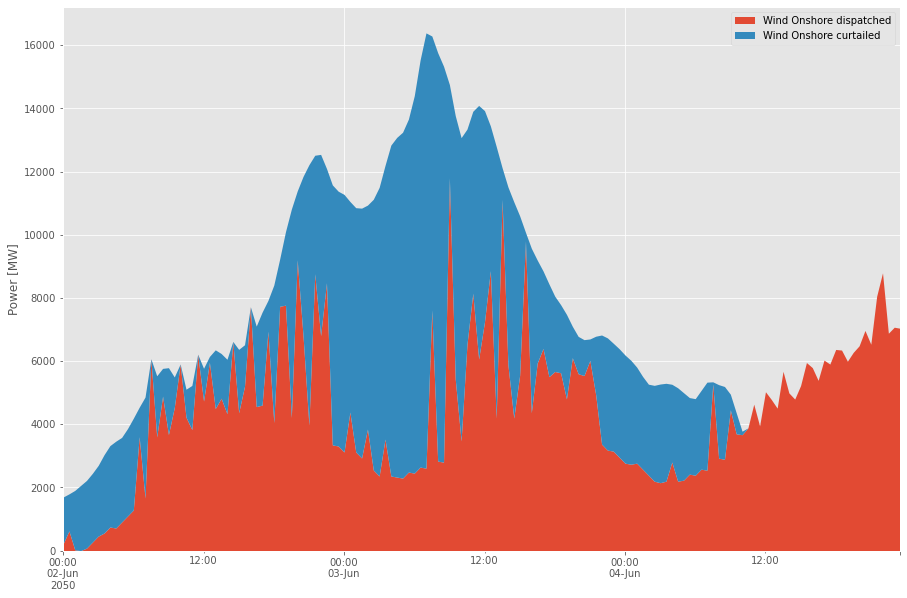

In [15]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()